In [37]:
from ldctinv.vae.blocks import ActNorm, GBlock, SelfAttention, SpectralNorm
import torch.nn.functional as F
from torch.nn import BatchNorm2d
import torch.nn as nn
import torch
import math

class Generator(nn.Module):
    def __init__(
        self, code_dim, z_dim, im_ch, n_class, chn, use_actnorm, cond_ch, output_size=128, latimage=False
    ):
        super().__init__()
        self.latimage = latimage
        self.z_dim = z_dim
        self.output_size = output_size
        self.num_layers = int(math.log2(output_size)) - 2  # Adjust layers based on output size
        
        self.sa_id = min(4, self.num_layers - 1)
        self.num_split = 6
        self.linear = nn.Linear(n_class, 128, bias=False)
        
        if self.latimage:
            split_size = 1
            self.first_view = z_dim // 64 - (self.num_split - 1) * split_size
            first_split = self.first_view
        else:
            split_size = 20
            self.first_view = (output_size // 8) ** 2 * chn
            first_split = z_dim - (self.num_split - 1) * split_size
            self.G_linear = SpectralNorm(nn.Linear(first_split, self.first_view))
        
        self.split_at = [first_split] + [split_size for _ in range(self.num_split - 1)]

        G_block_z_dim = 3 if self.latimage else code_dim + 28
        first_chn = first_split if self.latimage else self.first_view // (self.output_size // (2 ** self.num_layers)) ** 2
        
        channels = [first_chn] + [chn * (2 ** i) for i in range(self.num_layers - 1, -1, -1)]
        print(channels)
        
        self.GBlock = nn.ModuleList([
            GBlock(
                channels[i] + cond_ch, channels[i + 1],
                n_class=n_class, z_dim=G_block_z_dim, 
                upsample=not self.latimage, latimage=self.latimage
            ) for i in range(self.num_layers)
        ])
        
        self.attention = SelfAttention(channels[self.sa_id])
        self.ScaledCrossReplicaBN = BatchNorm2d(channels[-1], eps=1e-4) if not use_actnorm else ActNorm(channels[-1])
        self.colorize = nn.Conv2d(channels[-1] + cond_ch, im_ch, kernel_size=3, padding=1)

    def forward(self, input, class_id, im_cond=None):
        if self.latimage:
            input = input.view(-1, self.z_dim // 64, 8, 8)
        codes = torch.split(input, self.split_at, 1)
        class_emb = self.linear(class_id)
        
        if not self.latimage:
            out = self.G_linear(codes[0])
            side_length = self.output_size // (2 ** self.num_layers)
            out = out.view(-1, side_length, side_length, self.first_view // (side_length ** 2)).permute(0, 3, 1, 2)
        else:
            class_emb = class_emb.view(-1, 2, 8, 8)
            out = codes[0]
        
        for i, (code, GBlock) in enumerate(zip(codes[1:], self.GBlock)):
            if i == self.sa_id:
                out = self.attention(out)
            condition = torch.cat([code, class_emb], 1)
            if i > 1 and self.latimage:
                condition = F.interpolate(condition, scale_factor=2 ** (i - 1))
            if im_cond is not None:
                scale_factor = 1 / 2 ** (self.num_layers - i)
                im_cond_rescaled = F.interpolate(im_cond, scale_factor=scale_factor)
                out = torch.cat([out, im_cond_rescaled], 1)
            print(out.shape)
            out = GBlock(out, condition)
        
        out = self.ScaledCrossReplicaBN(out)
        if im_cond is not None:
            out = torch.cat([out, im_cond], 1)
        out = self.colorize(out)
        return out
    
    def encode(self, *args, **kwargs):
        raise RuntimeError("BigGAN architecture does not have an encoder")
    
    def decode(self, z, cls):
        z = z.float()
        cls_one_hot = torch.nn.functional.one_hot(cls, num_classes=1000).float()
        return self.forward(z, cls_one_hot)


In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [43]:
g = Generator(code_dim=120, z_dim=256, im_ch=1, n_class=1000, chn=96, use_actnorm=True, cond_ch=1, output_size=224, latimage=False).to(device)

[1536, 1536, 768, 384, 192, 96]


In [44]:
x_in = torch.randn(5, 256).to(device)
class_in = torch.randn(5, 1000).to(device)
im_cond = torch.randn(5, 1, 224, 224).to(device)
out = g(x_in, class_in, im_cond=im_cond)
print(out.shape)

torch.Size([5, 1537, 7, 7])
torch.Size([5, 1537, 14, 14])
torch.Size([5, 769, 28, 28])
torch.Size([5, 385, 56, 56])
torch.Size([5, 193, 112, 112])
torch.Size([5, 1, 224, 224])


In [2]:
from fff import FiberModel
import os
import torch 

model_folder = "/home/armand/helix_store/fiberlearning/lightning_logs/version_12/"

hparams_path = os.path.join(model_folder, "hparams.yaml")
checkpoint_path = os.path.join(model_folder, "checkpoints/last.ckpt")

ckpt = torch.load(checkpoint_path)
hparams = ckpt["hyper_parameters"]
hparams["data_set"]["root"] = "/mnt/SSD_2TB/ldct_data"
hparams["data_set"]["subject_model_path"] = "../notebooks/SubjectModels/saved_models/BiomedClip.pt"
hparams["lossless_ae"][-1]['latent_dim'] = 256
model = FiberModel(hparams)
model.load_state_dict(ckpt["state_dict"])
model.eval()
pass

/tmp/ipykernel_529099/3852956454.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path)


loading subject_model


/home/armand/miniconda3/lib/python3.10/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/armand/miniconda3/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


cond_dim:  0
output_dim:  512
spatial size:  1
num_channels_pre_fc:  2048


TypeError: Identity.__init__() missing 1 required positional argument: 'hparams'

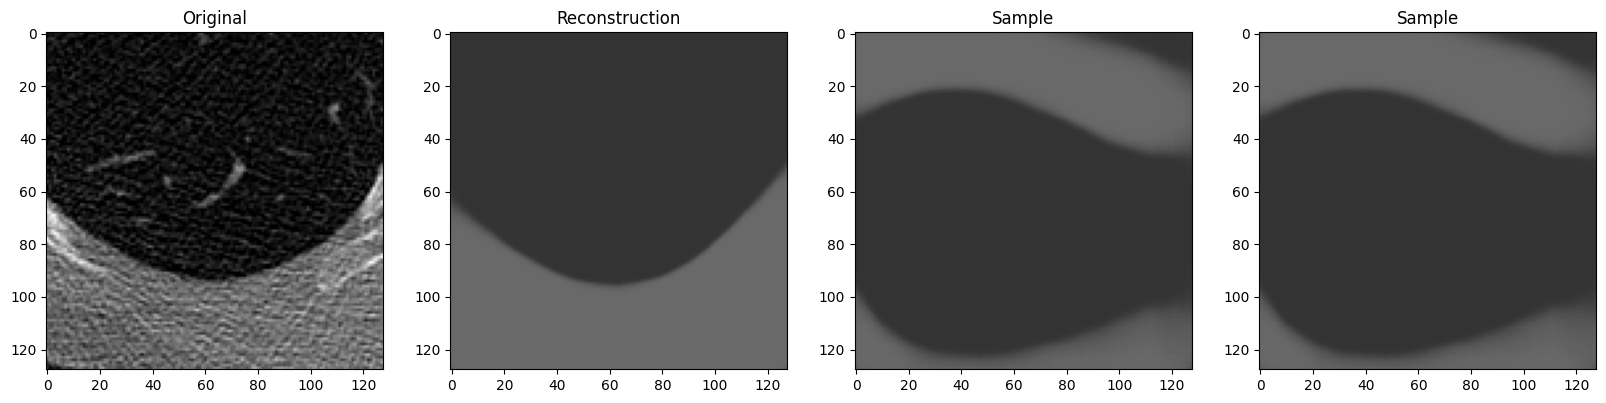

In [28]:
import matplotlib.pyplot as plt
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

with torch.no_grad():
    batch = model.val_data[0]
    batch = (batch[0].unsqueeze(0).to(device), batch[1].unsqueeze(0).to(device))
    conditioned = model.apply_conditions(batch)
    c = conditioned.condition.to(device)
    x0 = conditioned.x0.to(device)
    x_rec = model(x0, c)
    x_rec = x_rec.squeeze(0).reshape(1, 128, 128)
    samples = model.sample(torch.Size([2]), condition=torch.cat([c, c], 0)).reshape(2, 1, 128, 128)
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    # save color range:
    vmin = x0.min().item()
    vmax = x0.max().item()
    plt.imshow(x0.reshape(128, 128).cpu().numpy(), cmap="gray", vmin=vmin, vmax=vmax)
    plt.title("Original")
    plt.subplot(1, 4, 2)
    plt.imshow(x_rec.squeeze().cpu().numpy(), cmap="gray", vmin=vmin, vmax=vmax)
    plt.title("Reconstruction")
    plt.subplot(1, 4, 3)
    plt.imshow(samples[0].squeeze().cpu().numpy(), cmap="gray", vmin=vmin, vmax=vmax)
    plt.title("Sample")
    plt.subplot(1, 4, 4)
    plt.imshow(samples[0].squeeze().cpu().numpy(), cmap="gray", vmin=vmin, vmax=vmax)
    plt.title("Sample")

In [30]:
x0.min(), x0.max(), x_rec.min(), x_rec.max(), samples.min(), samples.max()

(tensor(-0.9587, device='cuda:0'),
 tensor(3.7985, device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(1., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(1.0000, device='cuda:0'))